In [1]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt
plt.style.use(['science', 'notebook', 'grid'])

This is just a simple system that will use fuzzy logic to determine if a concentric contraction is correct or not. Later I will expand upon this.

I will discritise the angle trajectory of each joint into e.g. 10 points, I will then acquire the "correct" angle at this point in normalised time from the Perfect Technique Regression Model. Next I will create a new variable which is essentially the error, this will be:
- error = Correct Angle - Actual Angle

this will be done at all 10 points. The error at all 10 points will be the inputs to the fuzzy logic system.

### Define Inputs

C:\Users\Cian\Anaconda\lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


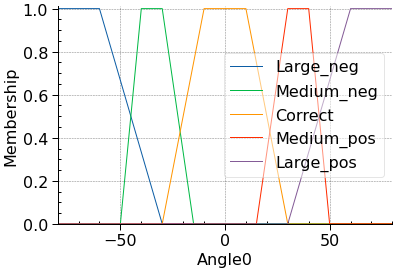

In [2]:
#now create an input to the fuzzy system for all 10 points
num_inputs = 15

#initiallize a dictionary that will contain all the inputs
inputs = {}
for i in range(num_inputs):
    #create the input
    inputs[f'Angle{i}'] = ctrl.Antecedent(np.arange(-80,81,1),f'Angle{i}')

#now fuzzify each input
for j in range(num_inputs):
    inputs[f'Angle{j}']['Large_neg'] = fuzz.trapmf(inputs[f'Angle{j}'].universe, [-80,-80,-60,-30])
    inputs[f'Angle{j}']['Medium_neg'] = fuzz.trapmf(inputs[f'Angle{j}'].universe, [-50,-40,-30,-15])
#     inputs[f'Angle{j}']['Small_neg'] = fuzz.trapmf(inputs[f'Angle{j}'].universe, [-35,-25,-20,-10])
    inputs[f'Angle{j}']['Correct'] = fuzz.trapmf(inputs[f'Angle{j}'].universe, [-30,-10,10,30])
#     inputs[f'Angle{j}']['Small_pos'] = fuzz.trapmf(inputs[f'Angle{j}'].universe, [10,20,25,35])
    inputs[f'Angle{j}']['Medium_pos'] = fuzz.trapmf(inputs[f'Angle{j}'].universe, [15,30,40,50])
    inputs[f'Angle{j}']['Large_pos'] = fuzz.trapmf(inputs[f'Angle{j}'].universe, [30,60,80,80])
    
#Show a plot of the input membership functions
inputs['Angle0'].view()

### Define the Output

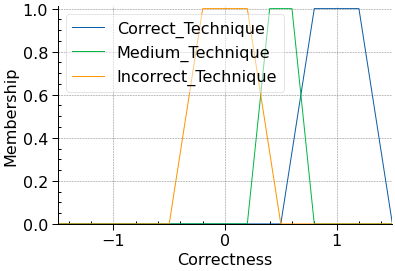

In [3]:
#define the output
correctness = ctrl.Consequent(np.arange(-1.5, 1.51, 0.01), 'Correctness')

#Now define its membership functions
correctness['Correct_Technique'] = fuzz.trapmf(correctness.universe,[0.5,0.8,1.2,1.5])
correctness['Medium_Technique'] = fuzz.trapmf(correctness.universe,[0.2,0.4,0.6,0.8])
correctness['Incorrect_Technique'] = fuzz.trapmf(correctness.universe,[-0.5,-0.2,0.2,0.5])

#now display the membership functions that define correctness
correctness.view()

### Create Logic-Based Rules

In [4]:
#initiallize an empty list that will contain all the rules.
rules = []

#all rules require comparison between all points, therefore loop through the inputs.
for i in range(num_inputs-1):
    #if all points are accurate compared to the model, then the technique is correct.
    rules.append(ctrl.Rule(inputs[f'Angle{i}']['Correct']&inputs[f'Angle{i+1}']['Correct'], correctness['Correct_Technique']))
    
    #If only one point is showing medium error then the technique should be of medium correctness.
    rules.append(ctrl.Rule(inputs[f'Angle{i}']['Medium_pos']|inputs[f'Angle{i+1}']['Medium_pos'], correctness['Medium_Technique']))
    rules.append(ctrl.Rule(inputs[f'Angle{i}']['Medium_neg']|inputs[f'Angle{i+1}']['Medium_neg'], correctness['Medium_Technique']))
    
    #If only one point is showing high error then the technique is incorrect.
    rules.append(ctrl.Rule(inputs[f'Angle{i}']['Large_pos']|inputs[f'Angle{i+1}']['Large_pos'], correctness['Incorrect_Technique']))
    rules.append(ctrl.Rule(inputs[f'Angle{i}']['Large_neg']|inputs[f'Angle{i+1}']['Large_neg'], correctness['Incorrect_Technique']))

### Define the System

In [5]:
system = ctrl.ControlSystem(rules)

### Apply System to Real Examples
I will now code a script that uses the classification model and the regression "perfect technique" model to create inputs to the fuzzy logic system. This will complete this section

In [6]:
#import all necessary packages
import numpy as np
from keras.utils import to_categorical
from scipy.interpolate import InterpolatedUnivariateSpline
import matplotlib.pyplot as plt
plt.style.use(['science', 'notebook', 'grid'])
import sys
sys.path.append("C:\\Users\\Cian\\1 FYP Code\\Code_with_git\\Functions")
from Functions import Bicep_Curl_Classification,equal_lengths

In [7]:
#First apply the Bicep_Curl_Classification function that I have created. This extracts the relevant angles for each frame in the video in addition to classifying each frame.
path = "C:\\Users\\Cian\\OneDrive\\Documents\\Imperial\\Year 4\\FYP\\Local Download\Technical\\Bicep Curl Analysis\\Technique Modelling\\Training Data (Videos)\\Incorrect Technique (for validation)\\2.mp4"
result, Angles = Bicep_Curl_Classification(path,"Final Model")

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step


Now extract the frames for each concentric and eccentric contraction.

In [1]:
#Identify the locations when the class changes
change = result[1:]*result[:-1]
C = np.where(np.sum((change == np.array([0,0,0])), axis=1) == 3)[0]

#Create a list representing the class of each chunk
class_chunk = [np.argmax(result[i+1]) for i in C-1]

#Initiallize lists that will containg the data sequences for concentric/eccentric contractions
concentric = []
eccentric = []

for i in range(len(class_chunk)):
    #define the beginning of the range of frames that represent the current chunk. We define the second index later
    #Note that we need to add 9 to the value value in C, this is because a prediction isn't made on the first 9 frames.
    ind0 = C[i-1]+1+9
    
    #if i==0 then the range of frames is from the beginning (the abouve definition for ind0 doesn't apply in this case)
    if i==0:
        ind0 = 0

    #if not a bicep curl at all
    if class_chunk[i] == 0:
        pass
    
    #if concentric contraction
    elif class_chunk[i] == 1:
        #if this is the final chunk
        if i==len(class_chunk)-1:
            concentric.append(Angles[ind0:])
        else:
            ind1 = C[i]+1+9
            concentric.append(Angles[ind0:ind1])
        
    #if eccentric contraction
    elif class_chunk[i]==2:
        #if this is the final chunk
        if i==len(class_chunk)-1:
            eccentric.append(Angles[ind0:])
        else:
            ind1 = C[i]+1+9
            eccentric.append(Angles[ind0:ind1])

NameError: name 'result' is not defined

Interpolate the data using cubic splines, then extract evenly spaced angle values. This gives the capability of changing the number of points that we sample.

In [9]:
#First loop through concentric
#Initiallize a new list that will take the concentric contraction trajectories of custom length.
custom_con = []
for i in range(len(concentric)):
    #create the normalised time
    t = np.linspace(0,1,len(concentric[i]))
    
    #now apply the equal_lengths function, and append the result to the custom_con list.
    custom_con.append(equal_lengths(concentric[i], t, num_inputs))
    
    
    
#take the same approach for the eccentric.
custom_ecc = []
for i in range(len(eccentric)):
    #create normalised time
    t = np.linspace(0,1,len(eccentric[i]))
    
    #apply the equal_lengths function and append the result to custom_ecc
    custom_ecc.append(equal_lengths(eccentric[i],t,num_inputs))
    
#change the angle from a normalised value to be in degrees
custom_con = np.array(custom_con)*180
custom_ecc = np.array(custom_ecc)*180

Acquire corresponding values for the ideal concentric/eccentric contraction.

In [2]:
#first import the models
con_coeff = np.load('C:\\Users\\Cian\\1 FYP Code\\Code_with_git\\Prototype 2\\Technique Modelling\\Models\\Concentric.npy')
ecc_coeff = np.load('C:\\Users\\Cian\\1 FYP Code\\Code_with_git\\Prototype 2\\Technique Modelling\\Models\\Eccentric.npy')

#create a normalised time scale
time = np.linspace(0,1,num_inputs)

#in order to get coordinates from the model we use matrix multiplication with a matrix where the first row is just ones, while the second row is the normalised times.
matrix = np.stack((np.ones(num_inputs),time))

#Now calculate the correct angles for concentric and eccentric. Convert to degrees by multiplying by 180.
#Also transpose these so that the angles increment with time down the rows (matching the eccentric and concentric contraction from before)
correct_con = (con_coeff@matrix*180).T
correct_ecc = (ecc_coeff@matrix*180).T

NameError: name 'np' is not defined

Now I will acquire the angle error for each dimension. Note that since there is a hierarchical order to the joints (as follows):
- Torso Angle
- Upper Arm Angle
- Lower Arm Angle

So, if there is an error in the torso angle there will automatically be an error in the upper and lower arm angles, therefore, to make a fair analysis, we need to subtract the error of joints higher on the hierarchy list from each joint lower on the hierarchy list.

In [11]:
#First loop through the concentric list
error_con = []
for i in range(len(custom_con)):
    #First calculate the error in the torso angle (top of the hierarchy)
    e0 = custom_con[i][:,0] - correct_con[:,0]
    
    #Now subtract this from the angles lower on the hierarchy
    upper_arm = custom_con[i][:,1] - e0
    lower_arm = custom_con[i][:,2] - e0
    
    #Now calculate the error in the upper arm angle
    e1 = upper_arm - correct_con[:,1]
    
    #now subtract this error from the remaining angle on the hierarchy (lower arm)
    lower_arm = lower_arm - e1
    
    #Find the error in the lower arm
    e2 = lower_arm - correct_con[:,2]
    
    #concatenate all errors and then append to the error list
    error_con.append(np.stack((e0,e1,e2),axis=1))
    
    
    
#now do the same with eccentric
error_ecc = []
for i in range(len(custom_ecc)):
    #First calculate the error in the torso angle (top of the hierarchy)
    e0 = custom_ecc[i][:,0] - correct_ecc[:,0]
    
    #Now subtract this from the angles lower on the hierarchy
    upper_arm = custom_ecc[i][:,1] - e0
    lower_arm = custom_ecc[i][:,2] - e0
    
    #Now calculate the error in the upper arm angle
    e1 = upper_arm - correct_ecc[:,1]
    
    #now subtract this error from the remaining angle on the hierarchy (lower arm)
    lower_arm = lower_arm - e1
    
    #Find the error in the lower arm
    e2 = lower_arm - correct_ecc[:,2]
    
    #concatenate all errors and then append to the error list
    error_ecc.append(np.stack((e0,e1,e2),axis=1))

Now apply the fuzzy logic to each dimension in the Concentric and Eccentric

In [12]:
simulation = ctrl.ControlSystemSimulation(system)
inp = error_ecc[0]

for i in range(num_inputs):
    simulation.input[f'Angle{i}'] = inp[i,0]
simulation.compute()
print('Correction degree of torso', simulation.output)

for i in range(num_inputs):
    simulation.input[f'Angle{i}'] = inp[i,1]
simulation.compute()
print('Correction degree of upper arm', simulation.output)

for i in range(num_inputs):
    simulation.input[f'Angle{i}'] = inp[i,2]
simulation.compute()
print('Correction degree of lower arm', simulation.output)

Correction degree of torso {'Correctness': 1.0000000000000002}
Correction degree of upper arm {'Correctness': 0.5667134293181033}
Correction degree of lower arm {'Correctness': 0.5000000000000001}
